# Модель предсказания оттока клиентов телекоммуникационной компании

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
 - Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
 - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
 - contract_new.csv — информация о договоре;
 - personal_new.csv — персональные данные клиента;
 - internet_new.csv — информация об интернет-услугах;
 - phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

 - customerID — идентификатор абонента;
 - BeginDate — дата начала действия договора;
 - EndDate — дата окончания действия договора;
 - Type — тип оплаты: раз в год-два или ежемесячно;
 - PaperlessBilling — электронный расчётный лист;
 - PaymentMethod — тип платежа;
 - MonthlyCharges — расходы за месяц;
 - TotalCharges — общие расходы абонента.

Файл personal_new.csv
 - customerID — идентификатор пользователя;
 - gender — пол;
 - SeniorCitizen — является ли абонент пенсионером;
 - Partner — есть ли у абонента супруг или супруга;
 - Dependents — есть ли у абонента дети.
 
Файл internet_new.csv
 - customerID — идентификатор пользователя;
 - InternetService — тип подключения;
 - OnlineSecurity — блокировка опасных сайтов;
 - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
 - DeviceProtection — антивирус;
 - TechSupport — выделенная линия технической поддержки;
 - StreamingTV — стриминговое телевидение;
 - StreamingMovies — каталог фильмов.

Файл phone_new.csv
 - customerID — идентификатор пользователя;
 - MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Предподготовка

### Подключение библиотек

In [1]:
!pip install phik
!pip install imblearn
!pip install catboost
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [2]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import time
import re
import warnings
import sklearn
np.warnings = warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import(
    MaxAbsScaler,
    PowerTransformer,
    OneHotEncoder,
) 

from sklearn.compose import(
    make_column_transformer, 
    ColumnTransformer
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from catboost import CatBoostClassifier

from sklearn.metrics import(
    roc_curve,
    auc, 
    roc_auc_score,
    accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay
) 

import phik

import seaborn as sns
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from pandas.plotting import scatter_matrix

In [3]:
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
factor = .8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

Введум переменную для фиксирования изначальных состояний

In [4]:
state = 25122023

### Загрузка данных

In [5]:
f_names = ['contract_new', 'personal_new', 'internet_new', 'phone_new']
datas = []

for i in range(4):
    try:
        datas.append(pd.read_csv('/datasets/' + f_names[i] + '.csv'))
    except:
        datas.append(pd.read_csv('https://code.s3.yandex.net/datasets/' + f_names[i] + '.csv'))

## Исследовательский анализ и предобработка данных

Для каждого файла откроем первые 5 строк таблицы

In [6]:
for i in range(4):
    display(f_names[i])
    display(datas[i].head())

'contract_new'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


'personal_new'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'internet_new'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'phone_new'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Поступим аналогично, применив метод `info()` для получения основных данных о таблицах и `describe()` для основных статистических данных.

In [7]:
for i in range(4):
    display(f_names[i])
    datas[i].info()

'contract_new'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'personal_new'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'internet_new'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'phone_new'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблицах содержится различное число строк, поэтому возможно придётся использовать не все данные, выясним это в дальнейшем во время преобработки.

На данном этапе пропусков не выявлено.

In [8]:
for i in range(4):
    display(f_names[i])
    display(datas[i].describe())

'contract_new'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'personal_new'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'internet_new'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0842-IWYCP,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'phone_new'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0310-VQXAM,No
freq,1,3390


Пройдём по каждой из таблиц `contract_new`, `personal_new`, `internet_new`, `phone_new`.

#### Предобработка и исследовательский анализ `contract_new`

In [9]:
contract_new = datas[0]
contract_new.info()
contract_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Посмотрим на уникальные значения в столбцах.

In [10]:
for i in contract_new.columns:
    print(f'Признак "{i}" имеет {len(contract_new[i].unique())} уникальных значений:')
    print(contract_new[i].unique(), '\n')

Признак "customerID" имеет 7043 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Признак "BeginDate" имеет 77 уникальных значений:
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '201

Можно заметить, что признак `TotalCharges`, хотя и содержит фактически числовые значения, но они записаны как строковые.

Проверим связь столбцов `BeginDate`, `EndDate`, `TotalCharges`, а также выясним из-за чего тип данных в `TotalCharges` - `object`.

In [11]:
contract_new.loc[
    contract_new['BeginDate'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'BeginDate'
].unique()

array([], dtype=object)

In [12]:
contract_new.loc[
    contract_new['EndDate'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'EndDate'
].unique()

array(['No'], dtype=object)

In [13]:
contract_new.loc[
    contract_new['TotalCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'TotalCharges'
].unique()

array([' '], dtype=object)

Проверим связаны ли эти специфические значения по столбцам

In [14]:
contract_new.loc[contract_new['EndDate'] == 'No', ['BeginDate', 'EndDate', 'TotalCharges']]

,BeginDate,EndDate,TotalCharges
0,2020-01-01,No,31.04
1,2017-04-01,No,2071.84
2,2019-10-01,No,226.17
3,2016-05-01,No,1960.6
4,2019-09-01,No,353.5
...,...,...,...
7038,2018-02-01,No,2035.2
7039,2014-02-01,No,7430.4
7040,2019-03-01,No,325.6
7041,2019-07-01,No,520.8


In [15]:
contract_new.loc[contract_new['TotalCharges'] == ' ', ['BeginDate', 'EndDate', 'TotalCharges', 'MonthlyCharges']]

,BeginDate,EndDate,TotalCharges,MonthlyCharges
488,2020-02-01,No,,52.55
753,2020-02-01,No,,20.25
936,2020-02-01,No,,80.85
1082,2020-02-01,No,,25.75
1340,2020-02-01,No,,56.05
3331,2020-02-01,No,,19.85
3826,2020-02-01,No,,25.35
4380,2020-02-01,No,,20.00
5218,2020-02-01,No,,19.70
6670,2020-02-01,No,,73.35


In [16]:
bet = contract_new.loc[contract_new['TotalCharges'] == ' ', ['BeginDate', 'EndDate', 'TotalCharges']]
for i in bet.columns:
    print(f'Признак "{i}" имеет {len(bet[i].unique())} уникальных значений:')
    print(bet[i].unique(), '\n')

Признак "BeginDate" имеет 1 уникальных значений:
['2020-02-01'] 

Признак "EndDate" имеет 1 уникальных значений:
['No'] 

Признак "TotalCharges" имеет 1 уникальных значений:
[' '] 



**Промежуточные выводы**

1. Датафрейм `contract_new` содержит 8 признаков и 7043 объекта.
2. Датафрейм не содержит пропусков.
3. Признак `customerID` содерижт идентификаторы клиентов. Перед обучением моделей его следует удалить, на данном этапе он нужен для соединения датафреймов.
4. Признаки `BeginDate` и `EndDate` содержат информацию о дате и месяце начала и окончания действия договора соответственно. Если `EndDate` содержит No, значит договор был активен 01.02.2020. Следует данные признаки заменить на числовые признаки, которые будут означать активность контракта и его  продолжительность, это позволит избежать привязки ко времени, которая может создать проблемы при обучении моделей. На их основе создадим признаки `active_contract` и `duration_contract`. Для корректного расчета продолжительности контракта, после создания поризнака `active_contract` и до создания `duration_contract` следует значения No признака `EndDate` заменить на числовое значение 2020-02-01.
    - Признак active_contract будет содержать 0, если EndDate содержит No, и 1, если EndDate содержит дату. Данный признак будет основой целевого признака в объедененном датафрейме при обучении моделей.
    - Признак duration_contract будет содержать информацию о продолжительности действия договора.
5. Признаки `Type`, `PaperlessBilling` и `PaymentMethod` категориальные. Их требуется трансформировать методом OneHotEncoder в Pipeline перед обучением модели.
6. Признаки `MonthlyCharges` и `TotalCharges` содержат числовые значения. При этом, признак `TotalCharges` имеет тип object и требует преобразования в тип float64. Пробелы в признаке `TotalCharges` требуется заменить на числовое значение 0, так как известно, что данные актуальны на 01.02.2020. У всех таких клиентов в столбце `BeginDate` стоит как раз 2020-02-01, что соотвествует этому числу, а значит указывает на то, что все данные клиенты новые и ещё не произвели ни одной оплаты. Также на это может указывать то, что в столбце `MonthlyCharges` у них не нулевые значения.
7. Названия признаков желательно привести к «змеиному стилю».

In [17]:
contract_new['active_contract'] = 1
contract_new.loc[contract_new['EndDate'] == 'No', 'active_contract'] = 0

In [18]:
contract_new['BeginDate'] = pd.to_datetime(
    contract_new['BeginDate'], 
    format='%Y-%m-%d'
)

contract_new.loc[contract_new['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract_new['EndDate'] = pd.to_datetime(
    contract_new['EndDate'], 
    format='%Y-%m-%d'
)

contract_new['duration_contract'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.components.days

contract_new = contract_new.drop(['BeginDate', 'EndDate'], axis=1)

In [19]:
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float64')

In [20]:
contract_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract_new.columns] 
contract_new = contract_new.rename(columns={'customer_i_d':'customer_id'})

contract_new.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'active_contract',
       'duration_contract'],
      dtype='object')

In [21]:
print(contract_new.info())
contract_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   active_contract    7043 non-null   int64  
 7   duration_contract  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB
None


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,duration_contract
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


На этом можно считать, что предобработка таблицы `contract_new` окончена. Продолжим предобработку далее.

**Предобработка и исследовательский анализ `personal_new`**

In [22]:
personal_new = datas[1]
personal_new.info()
personal_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [23]:
for i in personal_new.columns:
    print(f'Признак "{i}" имеет {len(personal_new[i].unique())} уникальных значений:')
    print(personal_new[i].unique(), '\n')

Признак "customerID" имеет 7043 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Признак "gender" имеет 2 уникальных значений:
['Female' 'Male'] 

Признак "SeniorCitizen" имеет 2 уникальных значений:
[0 1] 

Признак "Partner" имеет 2 уникальных значений:
['Yes' 'No'] 

Признак "Dependents" имеет 2 уникальных значений:
['No' 'Yes'] 



**Промежуточные выводы**

1. Датафрейм personal_new содержит 5 признаков и 7043 объекта.
2. Датафрейм не содержит пропусков.
3. Признак `customerID` содерижт идентификаторы клиентов. Перед обучением моделей его следует удалить, на данном этапе он нужен для соединения датафреймов.
4. Признаки `gender`, `SeniorCitizen`, `Partner` и `Dependents` бинарные категориальные. Их требуется трансформировать методом OneHotEncoder в Pipeline перед обучением модели.
5. Признак `SeniorCitizen` отличается от других категориальных бинарных признаков наличием числовых значений. Для его унификации с другими категориальными значениями требуется его значения 0 и 1 привести к No и Yes соответственно, а тип данных `SeniorCitizen` привести к типу object.
6. Названия признаков желательно привести к «змеиному стилю».

In [24]:
personal_new.loc[personal_new['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No' 
personal_new.loc[personal_new['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes' 

In [25]:
personal_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal_new.columns] 
personal_new = personal_new.rename(columns={'customer_i_d':'customer_id'})

personal_new.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [26]:
print(personal_new.info())
personal_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


На этом можно считать, что предобработка таблицы `personal_new` окончена. Продолжим предобработку далее.

**Предобработка и исследовательский анализ `internet_new`**

In [27]:
internet_new = datas[2]
print(internet_new.info())
internet_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [28]:
for i in internet_new.columns:
    print(f'Признак "{i}" имеет {len(internet_new[i].unique())} уникальных значений:')
    print(internet_new[i].unique(), '\n')

Признак "customerID" имеет 5517 уникальных значений:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Признак "InternetService" имеет 2 уникальных значений:
['DSL' 'Fiber optic'] 

Признак "OnlineSecurity" имеет 2 уникальных значений:
['No' 'Yes'] 

Признак "OnlineBackup" имеет 2 уникальных значений:
['Yes' 'No'] 

Признак "DeviceProtection" имеет 2 уникальных значений:
['No' 'Yes'] 

Признак "TechSupport" имеет 2 уникальных значений:
['No' 'Yes'] 

Признак "StreamingTV" имеет 2 уникальных значений:
['No' 'Yes'] 

Признак "StreamingMovies" имеет 2 уникальных значений:
['No' 'Yes'] 



**Промежуточные выводы**

1. Датафрейм `internet_new` содержит 8 признаков и 5517 объектов.
2. Датафрейм не содержит пропусков.
3. Признак `customerID` содерижт идентификаторы клиентов. Перед обучением моделей его следует удалить, на данном этапе он нужен для соединения датафреймов.
4. Признаки `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` и `StreamingMovies` бинарные категориальные. Их требуется кодировать с методом OneHotEncoder в Pipeline перед обучением модели.
5. Названия признаков желательно привести к «змеиному стилю».

In [29]:
internet_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet_new.columns] 
internet_new = internet_new.rename(columns={
    'customer_i_d':'customer_id', 
    'streaming_t_v':'streaming_tv'
})

internet_new.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [30]:
print(internet_new.info())
internet_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


На этом можно считать, что предобработка таблицы `internet_new` окончена. Продолжим предобработку далее.

**Предобработка и исследовательский анализ `phone_new`**

In [31]:
phone_new = datas[3]
print(phone_new.info())
phone_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Промежуточные выводы**

1. Датафрейм phone_new содержит 2 признака и 6361 объект.
2. Датафрейм не содержит пропусков.
3. Признак `customerID` содерижт идентификаторы клиентов. Перед обучением моделей его следует удалить, на данном этапе он нужен для соединения датафреймов.
4. Признак `MultipleLines` бинарный категориальный. Его требуется трансформировать методом OneHotEncoder в Pipeline перед трансформировать моделей.
5. Названия признаков желательно привести к «змеиному стилю».

In [32]:
phone_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone_new.columns] 
phone_new = phone_new.rename(columns={'customer_i_d':'customer_id'})

phone_new.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [33]:
print(phone_new.info())
phone_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


На данном этапе предобработку данны можно считать оконченной, прейдём к объединению данных.

## Объединение данных

In [34]:
print('Размерность датафрейма "contract_new":', contract_new.shape)
print('Размерность датафрейма "personal_new":', personal_new.shape)
print('Размерность датафрейма "internet_new":', internet_new.shape)
print('Размерность датафрейма "phone_new"   :', phone_new.shape)

Размерность датафрейма "contract_new": (7043, 8)
Размерность датафрейма "personal_new": (7043, 5)
Размерность датафрейма "internet_new": (5517, 8)
Размерность датафрейма "phone_new"   : (6361, 2)


Количество значений в датафреймах `contract_new` и `personal_new` совпадает. Соединим их, чтобы проверить полностью ли идентификаторы в них совпадают.

In [35]:
personal_new.join(contract_new.set_index('customer_id'), on='customer_id', how='outer').shape

(7043, 12)

Так как количество значений в объединённой таблице равно количеству значений в изначальных таблицах, то идентификаторы клиентов в этих таблицах полностью совпадают.

Эти датафреймы можно объединять в общий датафрейм `total_new` через join. Остальные датафреймы имеют меньшее количество объектов. Следовательно, их следует объединять с общим датафреймом через левый join.

Также следует предположить, что отсутствие значений в меньших датафреймах с информацией о приобретенных услугах — это либо не приобретенные услуги, либо отсутствие информации о приобретении. Значит, отсутствие значений можно интерпретировать как No в рамках принятой здесь типология, но лучше будем использовать значение NoValue, то есть отсутствие значения.

In [36]:
total_new = personal_new.join(contract_new.set_index('customer_id'), on='customer_id')
total_new = total_new.join(internet_new.set_index('customer_id'), on='customer_id', how='left')
total_new = total_new.join(phone_new.set_index('customer_id'), on='customer_id', how='left')

In [37]:
total_new = total_new.fillna('NoValue')

Объединение таблиц можно считать законченным. Перейдём к определению и изучению выборок.

## Выделение выборок

Разделим данные на тренировочную, валидационную и тестовую выборки в отношении 3:1 при помощи `train_test_split`. Будем использовать параметр `random_state=state`, где параметр `state=25122023` и `train_test_split=0.25` по требованиям проекта.

In [38]:
features = total_new.drop('active_contract', axis=1)
target = total_new['active_contract']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=state)

total_new_train = features_train.join(target_train)

In [39]:
target_train_0 = target_train.loc[target_train == 0].count(),
target_train_1 = target_train.loc[target_train == 1].count(),
target_test_0 = target_test.loc[target_test == 0].count()
target_test_1 = target_test.loc[target_test == 1].count()

target_train_0 = target_train_0[0]
target_train_1 = target_train_1[0]

display(pd.DataFrame({
    'Тип выборки':['Тренировочная', 'Тестовая'], 
    'Класс 0':[
        target_train_0, 
        target_test_0
    ], 
    'Класс 1':[
        target_train_1, 
        target_test_1
    ]
})) 


if target_train_0 == target_train_1:
    print('Классы в тренировочной выборке сбалансированы.') 
else:
    print('Классы в тренировочной выборке не сбалансированы.') 
    print(f'Класс 0: {(target_train_0/(target_train.shape[0])*100).round(2)}%') 
    print(f'Класс 1: {(target_train_1/(target_train.shape[0])*100).round(2)}%') 
print() 
if  target_test_0 == target_test_1:
    print('Классы в тестовой выборке сбалансированы.') 
else:
    print('Классы в тестовой выборке не сбалансированы.') 
    print(f'Класс 0: {(target_test_0/(target_test.shape[0])*100).round(2)}%') 
    print(f'Класс 1: {(target_test_1/(target_test.shape[0])*100).round(2)}%')

,Тип выборки,Класс 0,Класс 1
0,Тренировочная,4466,816
1,Тестовая,1476,285


Классы в тренировочной выборке не сбалансированы.
Класс 0: 84.55%
Класс 1: 15.45%

Классы в тестовой выборке не сбалансированы.
Класс 0: 83.82%
Класс 1: 16.18%


Классы в тренировочной выборке крайне несбалансированы, для лучшего обучения моделей возможно потребуется дальнейшая балансировка.

## Исследовательский анализ объединённого датафрейма

In [40]:
print(total_new_train.info())
total_new_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2450 to 1214
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5282 non-null   object 
 1   gender             5282 non-null   object 
 2   senior_citizen     5282 non-null   object 
 3   partner            5282 non-null   object 
 4   dependents         5282 non-null   object 
 5   type               5282 non-null   object 
 6   paperless_billing  5282 non-null   object 
 7   payment_method     5282 non-null   object 
 8   monthly_charges    5282 non-null   float64
 9   total_charges      5282 non-null   float64
 10  duration_contract  5282 non-null   int64  
 11  internet_service   5282 non-null   object 
 12  online_security    5282 non-null   object 
 13  online_backup      5282 non-null   object 
 14  device_protection  5282 non-null   object 
 15  tech_support       5282 non-null   object 
 16  streaming_tv       52

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,active_contract
2450,7602-MVRMB,Female,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.45,8270.50,2191,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,0
3159,5150-ITWWB,Male,Yes,No,No,Month-to-month,Yes,Electronic check,94.85,284.55,92,Fiber optic,No,No,No,No,Yes,Yes,Yes,0
4029,0019-GFNTW,Female,No,No,No,Two year,No,Bank transfer (automatic),45.05,2651.19,1675,DSL,Yes,Yes,Yes,Yes,No,No,NoValue,1
3195,0570-BFQHT,Female,No,No,No,Month-to-month,No,Electronic check,80.55,782.95,276,Fiber optic,No,Yes,Yes,No,No,No,No,0
5087,8739-QOTTN,Female,No,Yes,No,Month-to-month,No,Mailed check,20.35,44.36,62,NoValue,NoValue,NoValue,NoValue,NoValue,NoValue,NoValue,No,0


Для упорщения дальнейших операций создадим словарик из колонок объединённого датафрейма.

In [41]:
total_new_features = {
    'customer_id':'идентификатор абонента',
    'gender':'пол',
    'senior_citizen':'является ли абонент пенсионером',
    'partner':'есть ли у абонента супруг или супруга',
    'dependents':'есть ли у абонента дети',

    'type':'тип оплаты',
    'paperless_billing':'электронный расчётный лист',
    'payment_method':'тип платежа',
    'monthly_charges':'расходы за месяц',
    'total_charges':'общие расходы абонента',
    'active_contract':'активный договор (целевой признак)', 
    'duration_contract':'продолжительность договора в днях',

    'internet_service':'тип подключения',
    'online_security':'блокировка опасных сайтов',
    'online_backup':'облачное хранилище файлов для резервного копирования данных',
    'device_protection':'антивирус',
    'tech_support':'выделенная линия технической поддержки',
    'streaming_tv':'стриминговое телевидение',
    'streaming_movies':'каталог фильмов',

    'multiple_lines':'подключение телефона к нескольким линиям одновременно'
}

In [42]:
total_new_features

{'customer_id': 'идентификатор абонента',
 'gender': 'пол',
 'senior_citizen': 'является ли абонент пенсионером',
 'partner': 'есть ли у абонента супруг или супруга',
 'dependents': 'есть ли у абонента дети',
 'type': 'тип оплаты',
 'paperless_billing': 'электронный расчётный лист',
 'payment_method': 'тип платежа',
 'monthly_charges': 'расходы за месяц',
 'total_charges': 'общие расходы абонента',
 'active_contract': 'активный договор (целевой признак)',
 'duration_contract': 'продолжительность договора в днях',
 'internet_service': 'тип подключения',
 'online_security': 'блокировка опасных сайтов',
 'online_backup': 'облачное хранилище файлов для резервного копирования данных',
 'device_protection': 'антивирус',
 'tech_support': 'выделенная линия технической поддержки',
 'streaming_tv': 'стриминговое телевидение',
 'streaming_movies': 'каталог фильмов',
 'multiple_lines': 'подключение телефона к нескольким линиям одновременно'}

Графически представим распределение классов в объединённом датaфрейме.

Распределение значений признака "gender" (пол):


,count,unique,top,freq
Класс 0,4466,2,Male,2247
Класс 1,816,2,Male,447


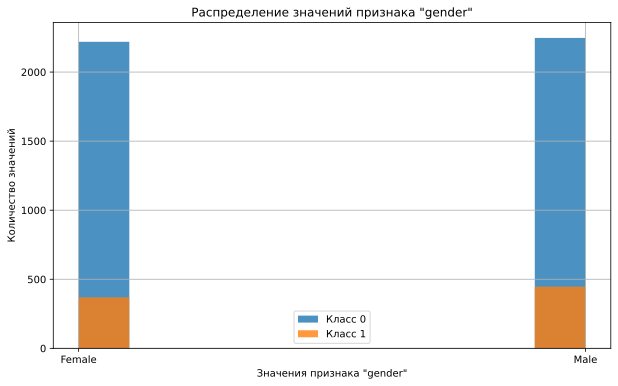

Распределение значений признака "senior_citizen" (является ли абонент пенсионером):


,count,unique,top,freq
Класс 0,4466,2,No,3781
Класс 1,816,2,No,649


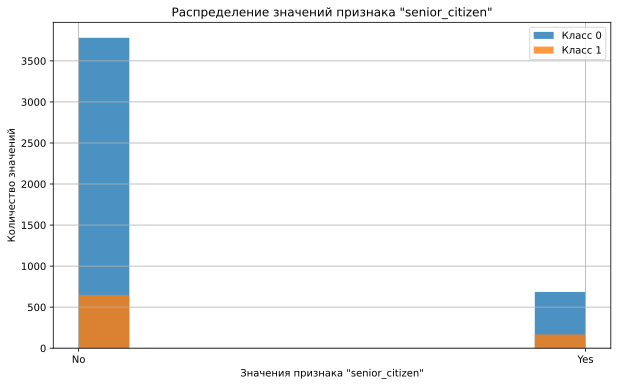

Распределение значений признака "partner" (есть ли у абонента супруг или супруга):


,count,unique,top,freq
Класс 0,4466,2,No,2440
Класс 1,816,2,Yes,534


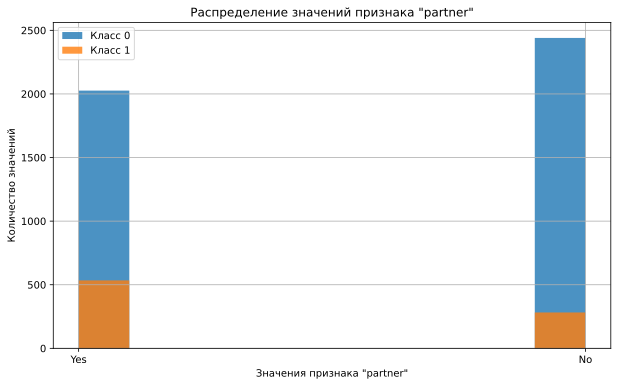

Распределение значений признака "dependents" (есть ли у абонента дети):


,count,unique,top,freq
Класс 0,4466,2,No,3158
Класс 1,816,2,No,541


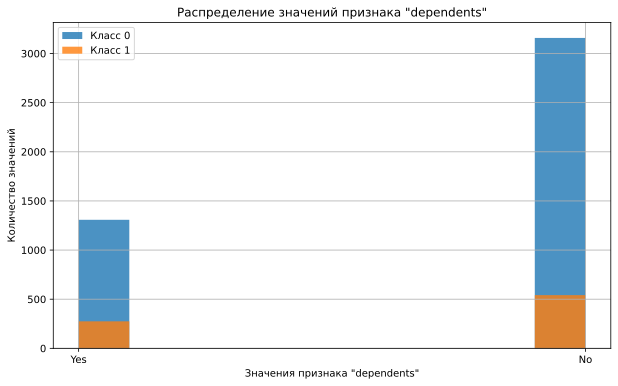

Распределение значений признака "type" (тип оплаты):


,count,unique,top,freq
Класс 0,4466,3,Month-to-month,2618
Класс 1,816,3,Month-to-month,297


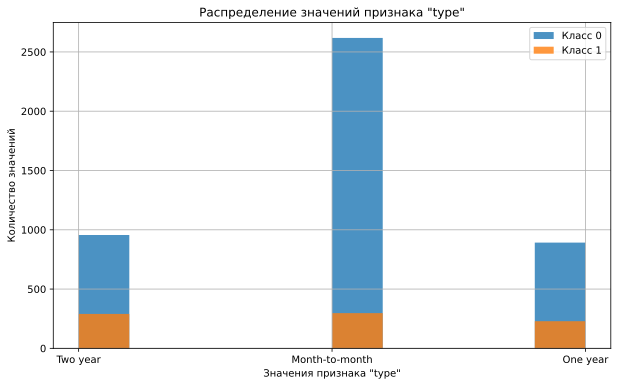

Распределение значений признака "paperless_billing" (электронный расчётный лист):


,count,unique,top,freq
Класс 0,4466,2,Yes,2595
Класс 1,816,2,Yes,525


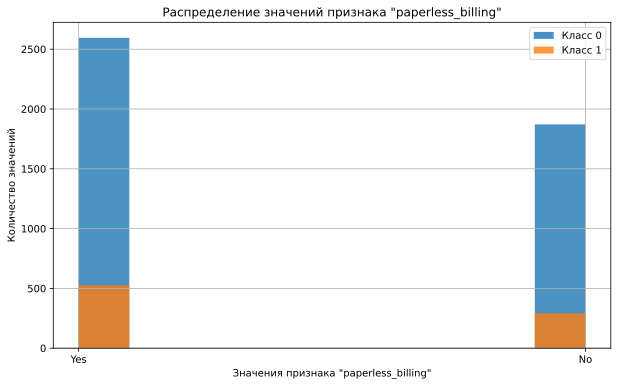

Распределение значений признака "payment_method" (тип платежа):


,count,unique,top,freq
Класс 0,4466,4,Electronic check,1519
Класс 1,816,4,Electronic check,254


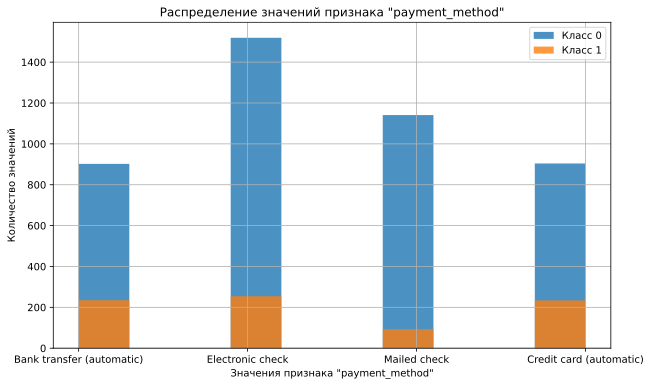

Распределение значений признака "monthly_charges" (расходы за месяц):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4466.0,62.396608,29.913049,18.25,29.5250,68.725,86.650,118.60
Класс 1,816.0,74.550061,29.284216,18.40,55.1875,83.400,98.725,118.75


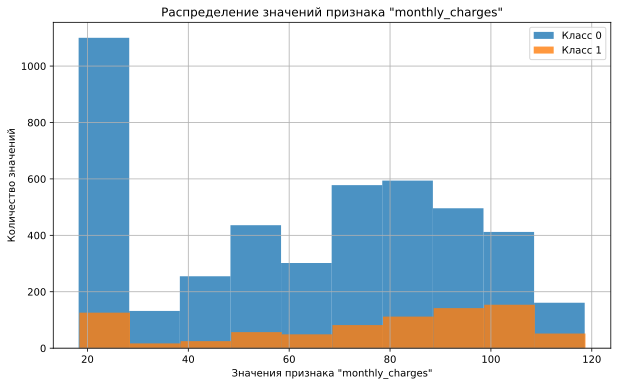

Распределение значений признака "total_charges" (общие расходы абонента):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4466.0,2049.128751,2177.714352,0.00,374.6950,1183.02,3115.6425,9221.38
Класс 1,816.0,2329.086789,1566.629282,77.84,1007.3625,2113.20,3339.0500,7567.56


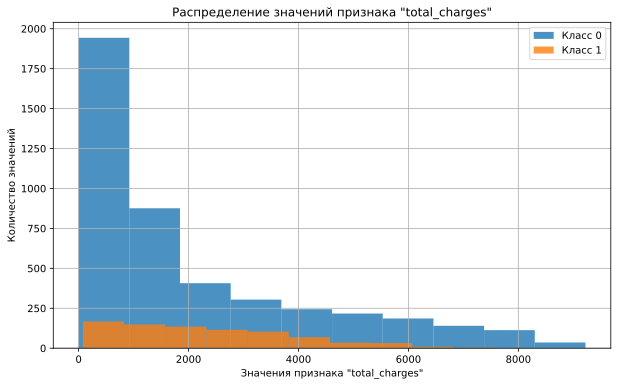

Распределение значений признака "duration_contract" (продолжительность договора в днях):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4466.0,890.299149,714.070404,0.0,245.0,702.0,1492.0,2314.0
Класс 1,816.0,918.908088,458.956132,30.0,577.0,913.0,1249.0,2070.0


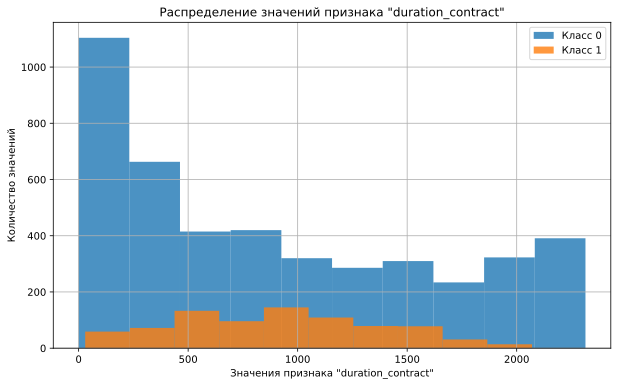

Распределение значений признака "internet_service" (тип подключения):


,count,unique,top,freq
Класс 0,4466,3,Fiber optic,1870
Класс 1,816,3,Fiber optic,423


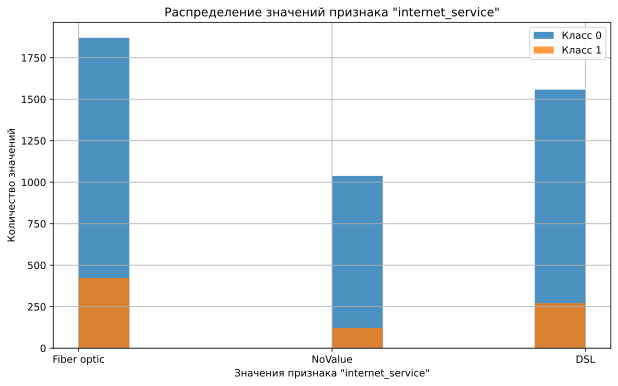

Распределение значений признака "online_security" (блокировка опасных сайтов):


,count,unique,top,freq
Класс 0,4466,3,No,2216
Класс 1,816,3,No,402


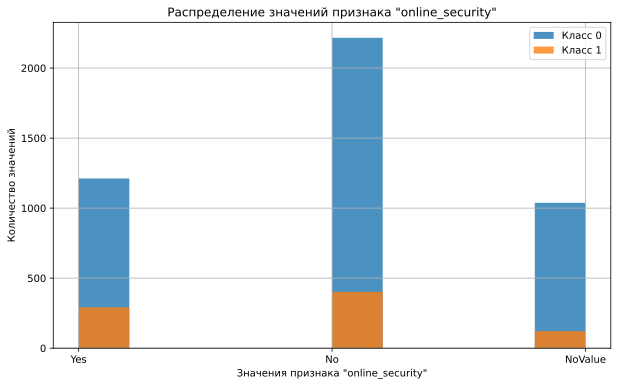

Распределение значений признака "online_backup" (облачное хранилище файлов для резервного копирования данных):


,count,unique,top,freq
Класс 0,4466,3,No,2037
Класс 1,816,3,Yes,427


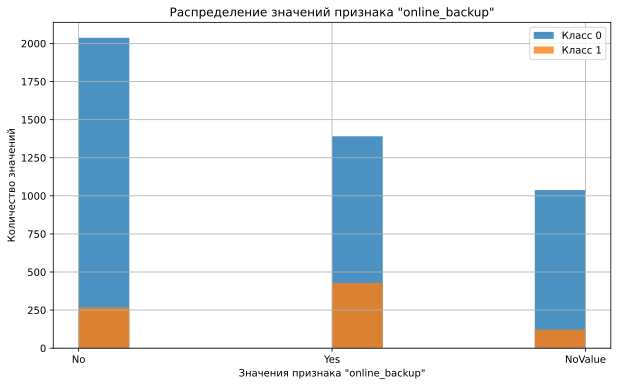

Распределение значений признака "device_protection" (антивирус):


,count,unique,top,freq
Класс 0,4466,3,No,2042
Класс 1,816,3,Yes,413


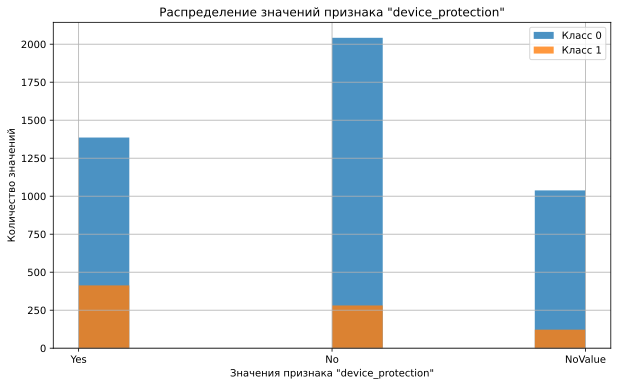

Распределение значений признака "tech_support" (выделенная линия технической поддержки):


,count,unique,top,freq
Класс 0,4466,3,No,2193
Класс 1,816,3,No,403


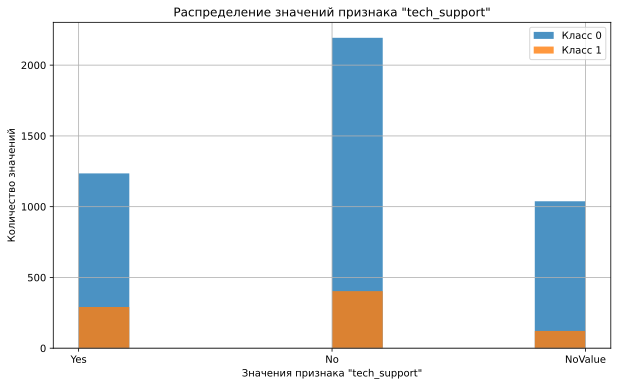

Распределение значений признака "streaming_tv" (стриминговое телевидение):


,count,unique,top,freq
Класс 0,4466,3,No,1872
Класс 1,816,3,Yes,427


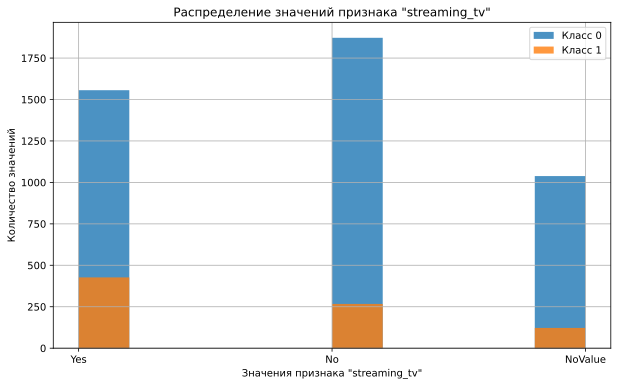

Распределение значений признака "streaming_movies" (каталог фильмов):


,count,unique,top,freq
Класс 0,4466,3,No,1855
Класс 1,816,3,Yes,448


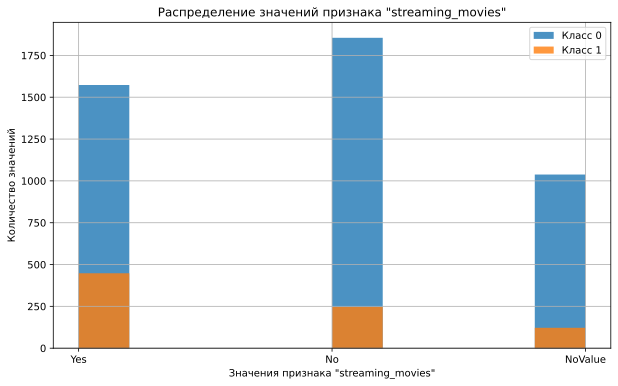

Распределение значений признака "multiple_lines" (подключение телефона к нескольким линиям одновременно):


,count,unique,top,freq
Класс 0,4466,3,No,2312
Класс 1,816,3,Yes,480


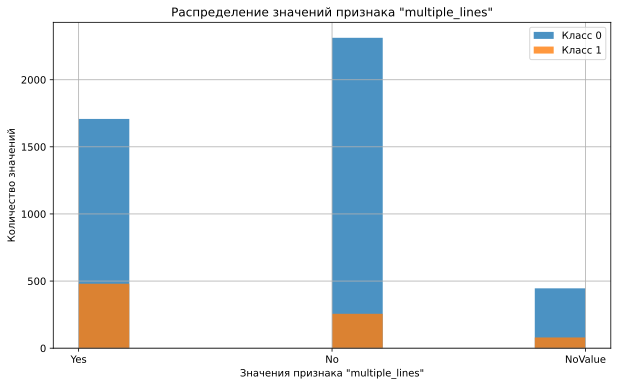

Распределение значений признака "active_contract" (активный договор (целевой признак)):


,count,mean,std,min,25%,50%,75%,max
Класс 0,4466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Класс 1,816.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


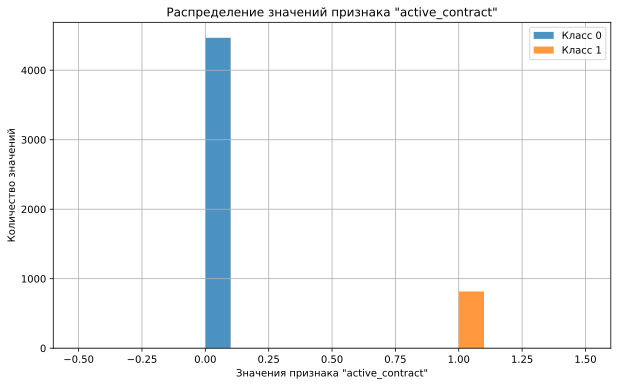

In [43]:
for i in total_new_train.columns:
    if i not in ['customer_id']:
        for j in total_new_train:
            if i == j:
                print(f'Распределение значений признака "{i}" ({total_new_features[j]}):')
                
                t0 = total_new_train.loc[total_new_train['active_contract'] == 0, i] 
                t1 = total_new_train.loc[total_new_train['active_contract'] == 1, i] 
                
                t0 = t0.rename('Класс 0') 
                t1 = t1.rename('Класс 1') 
                
                display(pd.DataFrame([t0.describe(), t1.describe()])) 
                
                t0.hist(legend=True, alpha=.8)
                t1.hist(legend=True, alpha=.8) 
                plt.title(f'Распределение значений признака "{i}"')
                plt.xlabel(f'Значения признака "{i}"')
                plt.ylabel('Количество значений')
                plt.show() 

Выделим числовые и категориальные переменные в отдельные переменные.

In [44]:
total_new_numeric = ['monthly_charges', 'total_charges', 'duration_contract']

print('Количество числовых признаков, требующих нормализации:', len(total_new_numeric))
total_new_train[total_new_numeric].head()

Количество числовых признаков, требующих нормализации: 3


,monthly_charges,total_charges,duration_contract
2450,110.45,8270.50,2191
3159,94.85,284.55,92
4029,45.05,2651.19,1675
3195,80.55,782.95,276
5087,20.35,44.36,62


In [45]:
total_new_categories = []

for i in total_new_train.columns:
    if (i not in total_new_numeric) & (i not in ['customer_id', 'active_contract']):
        total_new_categories.append(i)

print('Количество категориальных признаков, требующих кодирования методом "OneHotEncoder":', len(total_new_categories))
total_new_train[total_new_categories].head()

Количество категориальных признаков, требующих кодирования методом "OneHotEncoder": 15


,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
2450,Female,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
3159,Male,Yes,No,No,Month-to-month,Yes,Electronic check,Fiber optic,No,No,No,No,Yes,Yes,Yes
4029,Female,No,No,No,Two year,No,Bank transfer (automatic),DSL,Yes,Yes,Yes,Yes,No,No,NoValue
3195,Female,No,No,No,Month-to-month,No,Electronic check,Fiber optic,No,Yes,Yes,No,No,No,No
5087,Female,No,Yes,No,Month-to-month,No,Mailed check,NoValue,NoValue,NoValue,NoValue,NoValue,NoValue,NoValue,No


Изучим мультиколлинеарность данных.

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,active_contract
gender,1.000000,0.000000,0.000000,0.014670,0.000000,0.000000,0.031544,0.028614,0.036888,0.000000,0.000000,0.007883,0.000000,0.000000,0.000000,0.000000,0.000000,0.004752,0.044957
senior_citizen,0.000000,1.000000,0.027388,0.314786,0.080276,0.242037,0.293175,0.298014,0.152811,0.054599,0.157197,0.123866,0.108625,0.108418,0.132903,0.111090,0.113149,0.090978,0.074909
partner,0.000000,0.027388,1.000000,0.648332,0.184325,0.022288,0.240151,0.199561,0.371272,0.457613,0.000000,0.091173,0.086004,0.092528,0.071573,0.084628,0.073408,0.082803,0.224299
dependents,0.014670,0.314786,0.648332,1.000000,0.144719,0.172801,0.214081,0.175766,0.088292,0.196435,0.103644,0.108834,0.091140,0.088350,0.101144,0.084077,0.080527,0.002566,0.049241
type,0.000000,0.080276,0.184325,0.144719,1.000000,0.108057,0.273686,0.386503,0.465343,0.631737,0.503712,0.633159,0.579710,0.627264,0.666596,0.556337,0.556237,0.253941,0.098132
paperless_billing,0.000000,0.242037,0.022288,0.172801,0.108057,1.000000,0.376928,0.478214,0.207579,0.019588,0.238473,0.211082,0.197570,0.197964,0.203788,0.208337,0.203946,0.101835,0.067714
payment_method,0.031544,0.293175,0.240151,0.214081,0.273686,0.376928,1.000000,0.393196,0.331429,0.349455,0.316361,0.304778,0.284322,0.286565,0.315502,0.279814,0.281390,0.176612,0.211803
monthly_charges,0.028614,0.298014,0.199561,0.175766,0.386503,0.478214,0.393196,1.000000,0.715246,0.391470,0.919353,0.811707,0.816450,0.825687,0.814163,0.863466,0.862601,0.710075,0.209731
total_charges,0.036888,0.152811,0.371272,0.088292,0.465343,0.207579,0.331429,0.715246,1.000000,0.847238,0.493230,0.515787,0.547047,0.555818,0.517572,0.557870,0.554894,0.469228,0.296880
duration_contract,0.000000,0.054599,0.457613,0.196435,0.631737,0.019588,0.349455,0.391470,0.847238,1.000000,0.062026,0.344084,0.361931,0.371452,0.334558,0.313274,0.310064,0.350612,0.365686


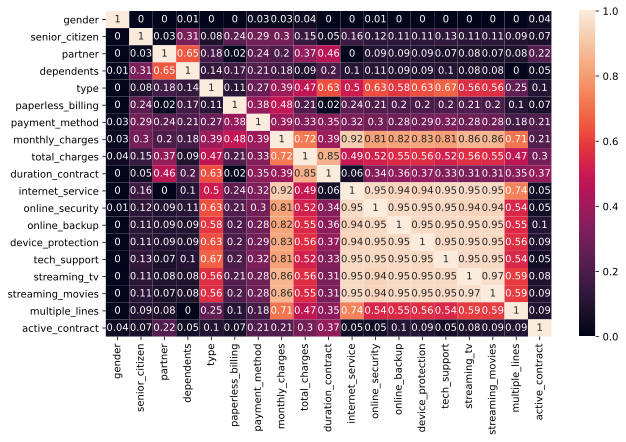

In [46]:
multicollinearity = total_new_train.drop('customer_id', axis=1).phik_matrix(interval_cols=total_new_numeric)
display(multicollinearity)

sns.heatmap(multicollinearity.copy().round(2), annot=True);

**Промежуточные выводы**

1. Тренировочная выборка `total_new_train`, полученная из объединенного датафрейма `total_new` содержит 20 признаков и 7043 объекта.
2. В объединенном датафрейме имеются 3 категориальных и 27 числовых признака. Часть из них не сбалансированы. Категориальные имеют дисбаланс классов, а числовые не не имеют нормального распределения или имеют существенное количество выбросов.
3. Признак `active_contract` является целевым для обучения. Он бинарный категориальный и не сбалансирован с перевесом в пользу значения 1 (контракт активен). Данный признак не содержит пропусков. Следовательно, по всем объектам выборки есть целевые значения.
4. Многие категориальные признаки содержат пропуски. Эти пропуски не требуется обрабатывать, т.к. не известны причины их появления.
5. Все категориальные признаки, в том числе те, что ранее содержали только 0 и 1, но кроме целевого, требуется кодировать методом OneHotEncoder.
6. Все числовые признаки, названия которых входят в переменную `total_new_numeric` (`monthly_charges`, `total_charges`, `duration_contract`), требуется нормализовать.

## Отбор признаков для использования в обучении моделей

В обучающую и тестовую выборки должны попасть только признаки, относительно высокойкорелируемые с целевым признаком. Из мультиколлинеарных признаков требуется оставить в выборках только те, что имеют большую корреляцию с целевым признаком.

Предлагается установить минимальный порог коррелируемости с целевым признаком в 0.03, чтобы отсечь данные, которые вероятно будут для модели лишними совсем, без нижней границы в финальный набор данных могут войти данные крайне слабо коррелирующие с целевым признаком.

Также предлагается установить максимальный порог мультиколлинеарности в 0.75, чтобы отсечь признаки, которые имеют крайне высокую корреляцию между собой, их отсечение позволит избежать мультиколлинераности, а соответственно и переобучения модели.

In [47]:
def non_multicollinear_features(m, target_feature, v_min, v_max):
    
    columns = [] 
    append = True
    
    for c in m.columns:
        if ((m[c][target_feature] > v_min) & (c != target_feature)): # проверка минимального порога коррелируемости с целевым признаком
            for i in m.index:
                if ((c != i) & (c != target_feature) & (c not in columns) & (i not in columns)): # проверка на мультиколлинеарность всех ещё недобавленных признаков
                    if m[c][i] > v_max:
                        if m[c][target_feature] < m[i][target_feature]:
                            append = False
                            break
            if append == True: columns.append(c) # создание списка признаков, которые войдут в финальную выборку
            append = True 
    
    return columns

columns = non_multicollinear_features(multicollinearity, 'active_contract', .03, .75)

print('Не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком:')
columns

Не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком:


['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'duration_contract',
 'online_backup',
 'device_protection',
 'streaming_movies',
 'multiple_lines']

In [48]:
features_categories = []
for i in columns:
    for j in total_new_categories:
        if i == j: features_categories.append(i)

features_numeric = []
for i in columns:
    for j in total_new_numeric:
        if i == j: features_numeric.append(i)

print('Категориальные признаки:', features_categories)
print()
print('Числовые признаки      :', features_numeric)

Категориальные признаки: ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method', 'online_backup', 'device_protection', 'streaming_movies', 'multiple_lines']

Числовые признаки      : ['monthly_charges', 'duration_contract']


## Подготовка данных

Подготовка данных для обучения модели. Разделение данных на две выборки, при масштабировании и кодировании должны быть учтены особенности данных и моделей.

Объединенный датафрейм ранее уже был разделен на обучающую и тренировочную выборки, а также на целевой и не целевые признаки. На треннировочной выборке выбраны не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком.

Названия этих признаков собраны в переменную `columns`. Учитывая выше сказанное требуется использовать ранее созданные выборки, но в выборках с «фичами» оставить только признаки, перечисленные в переменной `columns`.

Также перед обучением моделей следует удалить далее не используемые переменные, т.к. процесс обучения моделей ресурсоемкий.

In [49]:
features_train = features_train[columns]
features_test = features_test[columns]

In [50]:
print(features_train.info())
features_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2450 to 1214
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5282 non-null   object 
 1   senior_citizen     5282 non-null   object 
 2   partner            5282 non-null   object 
 3   dependents         5282 non-null   object 
 4   type               5282 non-null   object 
 5   paperless_billing  5282 non-null   object 
 6   payment_method     5282 non-null   object 
 7   monthly_charges    5282 non-null   float64
 8   duration_contract  5282 non-null   int64  
 9   online_backup      5282 non-null   object 
 10  device_protection  5282 non-null   object 
 11  streaming_movies   5282 non-null   object 
 12  multiple_lines     5282 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 706.8+ KB
None


,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,duration_contract,online_backup,device_protection,streaming_movies,multiple_lines
2450,Female,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.45,2191,No,Yes,Yes,Yes
3159,Male,Yes,No,No,Month-to-month,Yes,Electronic check,94.85,92,No,No,Yes,Yes
4029,Female,No,No,No,Two year,No,Bank transfer (automatic),45.05,1675,Yes,Yes,No,NoValue
3195,Female,No,No,No,Month-to-month,No,Electronic check,80.55,276,Yes,Yes,No,No
5087,Female,No,Yes,No,Month-to-month,No,Mailed check,20.35,62,NoValue,NoValue,NoValue,No


In [51]:
print(pd.DataFrame(target_train).info())
target_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2450 to 1214
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   active_contract  5282 non-null   int64
dtypes: int64(1)
memory usage: 211.6 KB
None


2450    0
3159    0
4029    1
3195    0
5087    0
Name: active_contract, dtype: int64

In [52]:
print(features_test.info())
features_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 5340 to 5742
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1761 non-null   object 
 1   senior_citizen     1761 non-null   object 
 2   partner            1761 non-null   object 
 3   dependents         1761 non-null   object 
 4   type               1761 non-null   object 
 5   paperless_billing  1761 non-null   object 
 6   payment_method     1761 non-null   object 
 7   monthly_charges    1761 non-null   float64
 8   duration_contract  1761 non-null   int64  
 9   online_backup      1761 non-null   object 
 10  device_protection  1761 non-null   object 
 11  streaming_movies   1761 non-null   object 
 12  multiple_lines     1761 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 192.6+ KB
None


,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,duration_contract,online_backup,device_protection,streaming_movies,multiple_lines
5340,Female,No,No,No,One year,No,Bank transfer (automatic),84.10,1157,Yes,Yes,Yes,Yes
1598,Male,No,Yes,No,Two year,No,Bank transfer (automatic),19.55,822,NoValue,NoValue,NoValue,No
3963,Female,No,No,No,Two year,No,Credit card (automatic),19.60,976,NoValue,NoValue,NoValue,No
493,Male,Yes,Yes,No,One year,No,Bank transfer (automatic),64.05,1857,Yes,No,Yes,Yes
4776,Female,No,Yes,No,Month-to-month,Yes,Electronic check,68.95,153,No,No,No,No


In [53]:
print(pd.DataFrame(target_test).info())
target_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 5340 to 5742
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   active_contract  1761 non-null   int64
dtypes: int64(1)
memory usage: 27.5 KB
None


5340    0
1598    0
3963    1
493     0
4776    0
Name: active_contract, dtype: int64

## Обучение моделей машинного обучения

Обучим несколько моделей машинного обучения.

Запишем несколько функций, которые потребуются в дальнейшем.

In [54]:
# Model + Params + Pipeline + HalvingGridSearchCV
def model_pipeline_gridsearch(
    features_train, 
    target_train, 
    pipeline, 
    params, 
    data_grids, 
    data_times 
):
    
    # Начало отслеживания времени
    start_time = time.time()
    
    # HalvingGridSearchCV
    grid = HalvingGridSearchCV(
        pipeline, 
        params,
        cv=3,
        scoring='roc_auc', 
        random_state=state
    ) 
    
    # Обучение
    grid.fit(features_train, target_train)
    
    # Подсчёт времени выполнения скрипта
    finish_time = time.time()
    funtion_time = finish_time - start_time
    
    data_grids.append(grid)
    data_times.append(funtion_time) 
    
    return data_grids, data_times

In [55]:
# Вывод на печать результатов модели
def print_model_result(grids, data_times, model_name, process_print=False):
    print()
    print('Модель         :', model_name)
    print('Метрика ROC AUC:', grids[-1].best_score_)
    print(f'Время          : {data_times[-1]} секунд')
    print('Параметры      :', grids[-1].best_estimator_[-1].get_params())
    print()
    if process_print == True:
        print('Результаты выбора параметров модели:')
        display(pd.DataFrame(grids[-1].cv_results_)[[
            'params', 
            'mean_train_score', 
            'mean_test_score'
        ]])
    print('-' * 30)

In [56]:
# Графическое представление результатов обучения и валидации модели
def print_model_graphicresult(grids, name):
    pd.DataFrame(grids[-1].cv_results_)[[
        'mean_test_score', 
        'mean_train_score'
    ]].plot(xlabel='Итерация HalvingGridSearchCV', ylabel='Усреднённое значение метрики AUC-ROC модели на фолдах тренировочной (train)\nи валидационной (test) выборок, составленных на основе\nизначальной тренировочной выборки', title=name);

In [57]:
# Переменная, содержащая баланс классов целевой переменной
class_weights = {
    1:target_train.loc[target_train == 1].count() / target_train.count(), 
    0:target_train.loc[target_train == 0].count() / target_train.count()
}

class_weights

{1: 0.15448693676637637, 0: 0.8455130632336236}

In [58]:
data_grids = []
data_times = []

### Обучение LogisticRegression


Модель         : LogisticRegression
Метрика ROC AUC: 0.7308015161093575
Время          : 16.258187294006348 секунд
Параметры      : {'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 25122023, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Результаты выбора параметров модели:


,params,mean_train_score,mean_test_score
0,"{'clf__C': 0.01, 'clf__solver': 'liblinear'}",0.748072,0.704081
1,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.760923,0.714264
2,"{'clf__C': 0.01, 'clf__solver': 'newton-cg'}",0.760923,0.714264
3,"{'clf__C': 0.1, 'clf__solver': 'liblinear'}",0.806414,0.707810
4,"{'clf__C': 0.1, 'clf__solver': 'lbfgs'}",0.814051,0.717994
5,"{'clf__C': 0.1, 'clf__solver': 'newton-cg'}",0.814072,0.717994
6,"{'clf__C': 0.2, 'clf__solver': 'liblinear'}",0.815529,0.707179
7,"{'clf__C': 0.2, 'clf__solver': 'lbfgs'}",0.820921,0.715278
8,"{'clf__C': 0.2, 'clf__solver': 'newton-cg'}",0.820921,0.715222
9,"{'clf__C': 0.5, 'clf__solver': 'liblinear'}",0.822778,0.707951


------------------------------


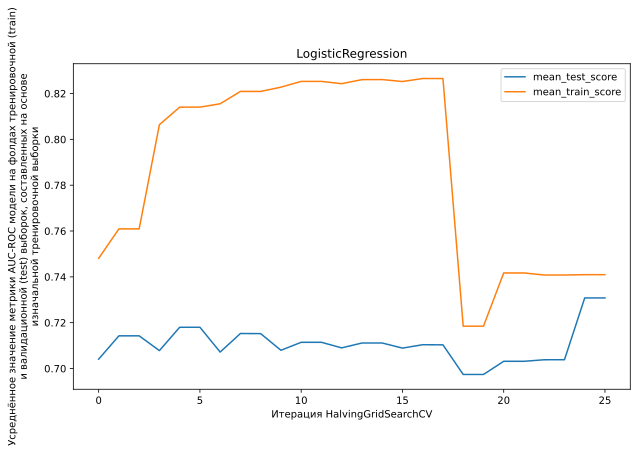

In [59]:
# LogisticRegression (solver, C)

# Модель
model = LogisticRegression(
    random_state=state, 
    class_weight='balanced'
) 

# Преобразование признаков
column_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories), # кодирование категорий через OneHotEncoder
    ('std', PowerTransformer(), features_numeric), # Приведение к нормальному распределению
], remainder='drop', verbose_feature_names_out=False)

# Pipeline
pipeline = Pipeline([
    ('transform', column_trans), # трансформация выборки
    ('clf', model) # модель классификации 
])

# Диапазон значений искомого параметра
n_С = [.01, .1, .2, .5, .7, .9]

# Параметры модели
params = [{
    'clf__solver': ('liblinear', 'lbfgs', 'newton-cg'),
    'clf__C': n_С
}]

# Обучение модели
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    pipeline, 
    params, 
    data_grids, 
    data_times 
)

# Вывод результата обучения модели
print_model_result(data_grids, data_times, 'LogisticRegression', process_print=True)

# График финальной версии модели этой ячейки
print_model_graphicresult(data_grids, 'LogisticRegression')

Была выбрана сетка гиперпараметров в виде:

`С` = [.01, .1, .2, .5, .7, .9]

`solver` = ['liblinear', 'lbfgs', 'newton-cg']

По графику можно заметить, что хотя изначально метрика AUC-ROC на тренировочной выборке растёт и находитсян а достаточно высоком показателе, данная же метрика либо остаётся практически неизменой на валидационной выборке, либо падает, что говорит о том, что изначально модель похоже переобучалась. В финале же метрика на тренировочной выборке снижается и почти сравнивается с метрикой на валидационной, но при этом и наблюдается самый высокий скачок вверх на валидационной выборке (а также наилучший результат на ней).

Наилучшая модель модель получилась на подбираемых параметрах `C`=0.1 и решателе `newton-cg`, при максимальной метрике  0.7308015161093575, то есть требуемый порог в 0,85 модель не преодолела.

### Обучение RandomForestClassifier


Модель         : RandomForestClassifier
Метрика ROC AUC: 0.8183635559401417
Время          : 115.30710339546204 секунд
Параметры      : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 25122023, 'verbose': 0, 'warm_start': False}

Результаты выбора параметров модели:


,params,mean_train_score,mean_test_score
0,"{'clf__max_depth': 1, 'clf__max_features': 'sq...",0.641631,0.711111
1,"{'clf__max_depth': 1, 'clf__max_features': 'sq...",0.779295,0.594444
2,"{'clf__max_depth': 1, 'clf__max_features': 'sq...",0.842220,0.629630
3,"{'clf__max_depth': 1, 'clf__max_features': 'sq...",0.864425,0.665432
4,"{'clf__max_depth': 1, 'clf__max_features': 'sq...",0.857892,0.672840
...,...,...,...
211,"{'clf__max_depth': 200, 'clf__max_features': '...",1.000000,0.772951
212,"{'clf__max_depth': 10, 'clf__max_features': 'l...",0.999159,0.779046
213,"{'clf__max_depth': 10, 'clf__max_features': 's...",0.999159,0.779046
214,"{'clf__max_depth': 10, 'clf__max_features': 'l...",0.987127,0.818364


------------------------------


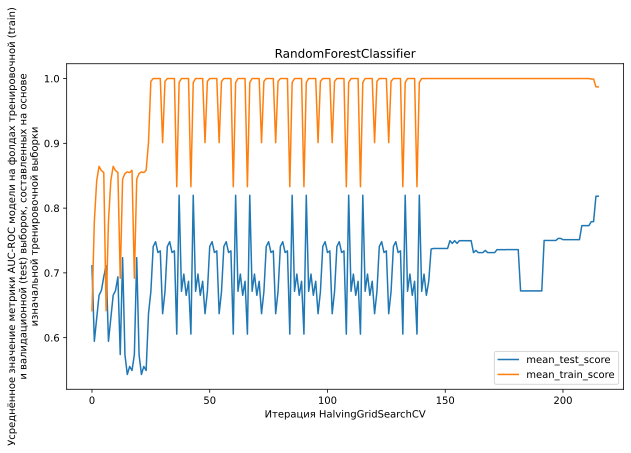

In [60]:
# RandomForestRegressor (max_features, max_depth)

# Модель
model = RandomForestClassifier(
    random_state=state
) 

# Преобразование признаков
column_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories), # кодирование категорий через OneHotEncoder
    ('std', MaxAbsScaler(), features_numeric), # Стандартизация числовых данных от 0 до 1
], remainder='drop', verbose_feature_names_out=False)

# Pipeline
pipeline = Pipeline([
    ('transform', column_trans), # трансформация выборки
    ('clf', model) # модель классификации 
])

# Диапазон значений искомого параметра
n_max_depth = [1, 10, 50, 100, 150, 200]
n_n_estimators = [1, 10, 50, 100, 150, 200]

params = [{
    'clf__max_features':('sqrt', 'log2', None, 1.), 
    'clf__max_depth': n_max_depth, 
    'clf__n_estimators': n_n_estimators
}]

data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    pipeline, 
    params, 
    data_grids, 
    data_times 
)

# Вывод результата обучения модели
print_model_result(data_grids, data_times, 'RandomForestClassifier', process_print=True)
    
# График финальной версии модели этой ячейки
print_model_graphicresult(data_grids, 'RandomForestClassifier')

Была выбрана сетка гиперпараметров в виде:

`max_depth` = [1, 10, 50, 100, 150, 200]

`n_estimators` = [1, 10, 50, 100, 150, 200]

`max_features` = ['sqrt', 'log2', None, 1.] 

По графику можно заметить, что метрика AUC-ROC на тренировочной выборке на достаточно большом количестве итераций находится на значениях близких или равных 1, что говорит о переобчении модели (также можно заметить по падающим результатам модели на валидационной выборке). Наилучшие результаты AUC-ROC на валидационной выборке модель показывает как раз в моменты, когда эта метрика на тренировочной выборке заметно отличается от 1.

Наилучшая модель модель получилась на подбираемых параметрах `max_depth`=10 и `n_estimators`=200, при максимальной метрике  0.8183635559401417, то есть требуемый порог в 0,85 модель не преодолела.

### Обучение модели CatBoostClassifier


Модель         : CatBoostClassifier
Метрика ROC AUC: 0.8679795853813584
Время          : 673.7369699478149 секунд
Параметры      : {'logging_level': 'Silent', 'random_state': 25122023, 'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1500}

Результаты выбора параметров модели:


,params,mean_train_score,mean_test_score
0,"{'clf__depth': 1, 'clf__learning_rate': 0.001,...",0.883871,0.633333
1,"{'clf__depth': 1, 'clf__learning_rate': 0.001,...",0.892773,0.630864
2,"{'clf__depth': 1, 'clf__learning_rate': 0.001,...",0.897654,0.627160
3,"{'clf__depth': 1, 'clf__learning_rate': 0.001,...",0.908056,0.643210
4,"{'clf__depth': 1, 'clf__learning_rate': 0.01, ...",0.913449,0.624691
...,...,...,...
147,"{'clf__depth': 5, 'clf__learning_rate': 0.001,...",0.878945,0.812878
148,"{'clf__depth': 5, 'clf__learning_rate': 0.01, ...",0.967491,0.815837
149,"{'clf__depth': 7, 'clf__learning_rate': 0.01, ...",0.930865,0.811673
150,"{'clf__depth': 5, 'clf__learning_rate': 0.01, ...",0.913842,0.850409


------------------------------


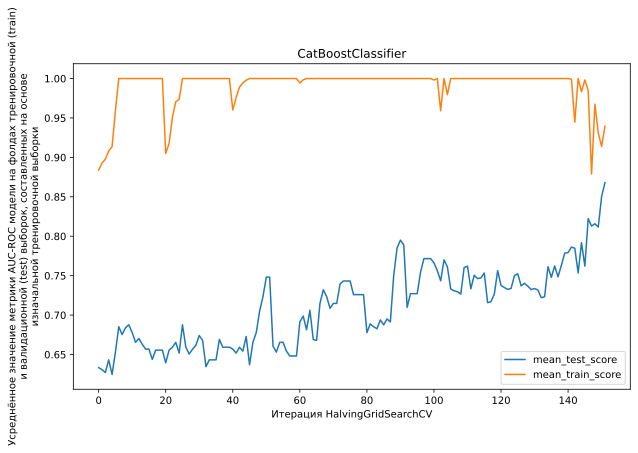

In [61]:
# CatBoostClassifier

# Модель
model = CatBoostClassifier(
    logging_level='Silent', 
    random_state=state
) 

# Преобразование признаков
column_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories), # кодирование категорий через OneHotEncoder
    ('std', MaxAbsScaler(), features_numeric), # Стандартизация числовых данных от 0 до 1
], remainder='drop', verbose_feature_names_out=False)

# Pipeline
pipeline = Pipeline([
    ('transform', column_trans), # трансформация выборки
    ('clf', model) # модель классификации 
])

# Диапазон значений искомого параметра
# depth
n_depth = [1, 2, 3, 5, 7]
# n_estimators
n_n_estimators = [200, 500, 1000, 1500] 
# learning_rate
n_learning_rate = [.001, .01, .1, .2, .3]

params = [{
    'clf__depth': n_depth, 
    'clf__n_estimators': n_n_estimators, 
    'clf__learning_rate': n_learning_rate
}]

# Обучение модели
data_grids, data_times = model_pipeline_gridsearch(
    features_train, 
    target_train, 
    pipeline, 
    params, 
    data_grids, 
    data_times 
)

# Вывод результата обучения модели
print_model_result(data_grids, data_times, 'CatBoostClassifier', process_print=True)

# График финальной версии модели этой ячейки
print_model_graphicresult(data_grids, 'CatBoostClassifier')

Была выбрана сетка гиперпарметров виде:

`depth` = [1, 2, 3, 5, 7]

`n_estimators` = [200, 500, 1000, 1500] 

`learning_rate` = [.001, .01, .1, .2, .3]

По графику можно заметить, что когда метрика AUC-ROC достигает значений, равных или около 1 на тренировочной кроссвалидационной выборке, то  модель при этом не получает лучшие результаты при кросс-валидации на тестовой  кроссвалидационной выборке.

Наилучшая модель модель получилась на подбираемых параметрах `learning_rate`=0.01, `depth`=5, `n_estimators`=1500, при максимальной метрике  0.8679795853813584, то есть требуемый порог в 0,85 модель преодолела.

## Выбор лучшей модели

Выбор лучшей модели и проверка её качества на тестовой выборке.

In [62]:
data_grids_best = data_grids[0]
data_times_best = data_times[0]
n = 0
for i in range(0, len(data_grids)):
    if data_grids[i].best_score_ > data_grids_best.best_score_:  
        data_grids_best = data_grids[i]
        data_times_best = data_times[i]

print('Лучшее время             :', data_times_best)
print('Лучший показатель ROC AUC:', data_grids_best.best_score_)
print('Лучшая модель            :') 
print(data_grids_best) 
print('Лучшие параметры модели  :') 
data_grids_best.get_params()

Лучшее время             : 673.7369699478149
Лучший показатель ROC AUC: 0.8679795853813584
Лучшая модель            :
HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('transform',
                                               ColumnTransformer(transformers=[('ohe',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore'),
                                                                                ['gender',
                                                                                 'senior_citizen',
                                                                                 'partner',
                                                                                 'dependents',
                                                                                 'type',
               

{'aggressive_elimination': False,
 'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('transform',
   ColumnTransformer(transformers=[('ohe',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['gender', 'senior_citizen', 'partner',
                                     'dependents', 'type', 'paperless_billing',
                                     'payment_method', 'online_backup',
                                     'device_protection', 'streaming_movies',
                                     'multiple_lines']),
                                   ('std', MaxAbsScaler(),
                                    ['monthly_charges', 'duration_contract'])],
                     verbose_feature_names_out=False)),
  ('clf', <catboost.core.CatBoostClassifier at 0x7f8e75b746a0>)],
 'estimator__verbose': False,
 'estimator__transform': ColumnTra

**Промежуточные выводы:**

В резуьтате выбора модели на основе метрики ROC AUC лучшие результат у модели CatBoostClassifier с гиперпараметрами {'logging_level': 'Silent', 'random_state': 25122023, 'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1500} показатель ROC AUC равен 0.8679795853813584.

### Анализ и тестирование лучшей модели

In [63]:
start_time = time.time()

predict = data_grids_best.predict(features_test)
predict_proba = data_grids_best.predict_proba(features_test)

finish_time = time.time()
funtion_time = finish_time - start_time

In [64]:
roc_auc = roc_auc_score(target_test, predict_proba[:, 1])
print('Показатель ROC AUC:', roc_auc)
print(f'Время предсказания: {funtion_time} секунд')

Показатель ROC AUC: 0.8854882803213997
Время предсказания: 0.0688028335571289 секунд


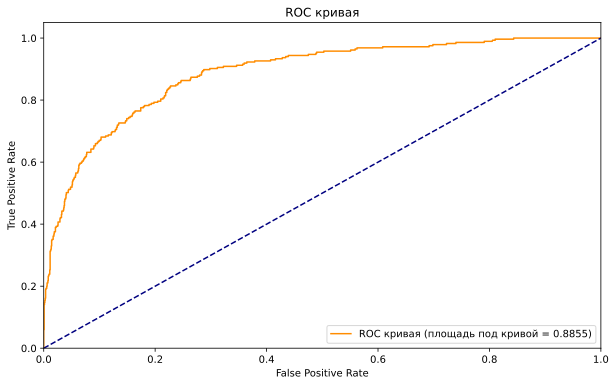

In [65]:
fpr, tpr, treshold = roc_curve(target_test, predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(
    fpr, 
    tpr, color='darkorange', 
    label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc
)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

ROC кривая сильно выпуклая вверх. Под ней большая часть всего прямоугольника, в который она вписана. Это означает, что модель в большинстве случаев правильно предсказывает целевые значения

In [66]:
print('Показатель Accuracy:', accuracy_score(target_test, predict)) 

Показатель Accuracy: 0.8813174332765474


В 88,1% случаев выбранная модель правильно предсказывает класс объекта. Это хороший результат, но здесь важно учесть дисбаланс классов, который может привести к лучшей предстказуемости большего класса. В случае данного проекта это класс 0 (договор не расторгнут). Точный расклад по количеству предсказанных объектов разного класса видно на матрице ошибок.

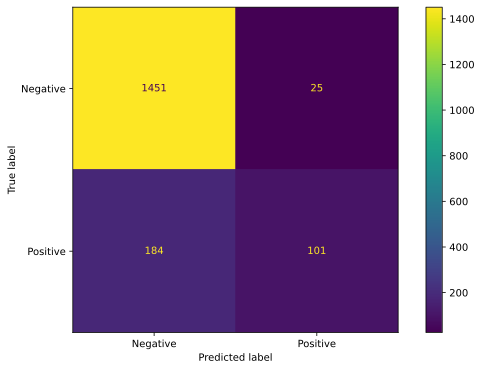

In [67]:
cm = confusion_matrix(target_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

Анализ матрицы ошибок показывает, что протестированная модель правильно предсказывает большую часть класса 0 (на графике горизонталь «Negative», договор не расторгнут). Ошибки в этом случае составляют около 2%. Значительно хуже обстоят дела с предсказанием класса 1 (на графике горизонталь «Positive», договор расторгнут). Здесь правильно предсказано только 1/3 всех значений. Вывод. Модель эффективно предскажет пользователя, который не собирается расторгать договор, но только в 1 из 3 случаев правильно предскажет будет ли пользователь расторгать договор.

In [68]:
# Анализ важности признаков
pd.DataFrame(
    data_grids_best.best_estimator_[-1].feature_importances_, 
    index=data_grids_best.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

,Важность признака
duration_contract,52.487114
monthly_charges,9.431397
type_Two year,7.669135
partner_Yes,4.727592
multiple_lines_Yes,3.509379
type_One year,3.374332
online_backup_Yes,3.154972
payment_method_Mailed check,3.052556
device_protection_Yes,1.900380
multiple_lines_NoValue,1.799125


Анализ важности признаков выявил бесспорного лидера — `duration_contract` (продолжительность договора в днях). Следом за ним с большим отрывом располагается признак `monthly_charges`. Не смотря на разрыв с лидером по важности, этот признак тоже кратно превосходит третью позицию в этом рейтинге — `type_Two Year`. Изменение этих признаков приведет к значительному изменению предсказаний. Замыкает этот рейтинг признак `paperless_billing_Yes`. Изменение этого признака в наименьшей степени повлияет на предсказание.

## Общий вывод и рекоммендации заказчику
Общий вывод о проделанной работе: описание основных этапов работы, полученных результатов и рекомендации для бизнеса.

#### Общий вывод

Цель данного проекта достигнута. Для предсказания оттока клиентов компании «ТелеДом» в продакшене рекоммендуется использовать модель машинного обучения `CatBoostClassifier` с гиперпараметрами `{'logging_level': 'Silent', 'random_state': 25122023, 'depth': 5, 'learning_rate': 0.01, 'n_estimators': 1500}`. При тестировании данная модель имеет значение показателя ROC AUC равное 0.8616043835876955, что выше требуемого уровня в 0.85.

#### Рекоммендации заказчику

Модель `CatBoostClassifier` с подобранными гиперпараметрами дает значение показателя ROC AUC выше требуемого. При возникновении потребности доведения этого показателя выше полученного здесь значения, предлагается рассмотреть возможность в дальнешем использовать модели нейронных сетей. Например, `Keras (TensorFlow)`, которая на тех же данных может показать еще более высокий результат.

Также, возможно, следует изменить подход к требованиям данного проекта. Так, после расчета «технической» метрики, коей является ROC AUC, можно расчитать бизнес-метрику. Например, финансовые потери от ухода клиента. Тогда, предсказанные только 1 из 3 ушедших клиентов могут оказаться существенной потерей и потребуется дообучить модель так, чтобы она чаще правильно предсказывала уход клиентов.

Прошу обратить внимание на исходные данные для данного проекта. Типы данных не оптимальны. Возможно, требуется оптимизация системы хранения данных. Так, например, параметр `TotalCharges` из файла `contract_new.csv` имеет тип `object` при том, что он содержит числовые значения с плавающей точкой. Еще более существенным является хранение категориальных бинарных признаков, таких как `PaperlessBilling` из файла `contract_new.csv`, с типом `object` содержащих текстовые значения. Изменение типа подобных переменных на `bool` или даже `int8` с бинарными значениями сделает таблицы легче без потери информативности. Также, прошу обратить внимание на пропуски в данных о клиентах. Это не очевидно при использовании разрозненных таблиц, но при их объединении проявляются объекты, содержащие пропуски по некоторым параметрам. Т.е., отсутствует информация по некоторым продуктам, которые используют клиенты.

Важно также обратить внимание на то, что большая часть признаков всех исходных датафреймов не пригодны для использования в моделях машинного обучения из-за их мультиколлинеарности и не достаточной парной корреляции с целевым признаком. Так, в результате исследовательского анализа для дальнейшего использования были выбраны:

1. Целевой признак `active_contract`. Он указывает на наличие или отсутствие действующего договора с клиентом. Возможно, в следствие его значимости, требуется хранить в используемой системе хранения в бинарном виде.
2. Категориальные признаки: `multiple_lines`, `paperless_billing`, `payment_method`, `tech_support`, `internet_service`.
3. Числовые признаки: `total_charges`, `duration_contract`.

#### Выводы о проделанной работе

В проекте использованы наиболее распространенные типы моделей машинного обучения `LogisticRegression`, `RandomForestClassifier` и `CatBoostClassifier`. Однако, минимальный порог по метрике ROC AUC преодолела только модель `CatBoostClassifier`. В перспективе ее промышленной эксплуатации на схожих данных ей будет помогать задействованные в проекте кросс-валидация и оптимизация показателей с использованием `Pipeline` и `HalvingGridSearchCV`.

Для достижения поставленной цели проекта было выполнено:

1. Подготовлена тетрадь Jupyter Notebook. Обновлены существующие и установлены новые библиотеки. В тетрадь загружены требуемые в проекте библиотеки. Оптимизировано отображение контента в тетради. Добавлены глобальные переменные.
2. Загружены и проверены данные из файлов.
3. Проведены исследовательский анализ и предобработка данных исходных датафреймов `contract_new` (информация о договоре), `personal_new` (персональные данные клиента), `internet_new` (информация об интернет-услугах) и `phone_new` (информация об услугах телефонии).
4. Данные исходных датафреймов объеденены в единый датафрейм. Из него предварительно выделены тренировочные выборки для анализа.
5. Проведены исследовательский анализ и предобработка данных предварительно выделенной треннировочной выборки из объединённого датафрейма. Были проведены анализ мультиколлинеарности и парной корреляции. Отобраны признаки для использования в обучении моделей.
6. Подготовлены данные к использованию в обучении моделей.
7. Обучены модели машинного обучения `LogisticRegression`, `RandomForestClassifier` и `CatBoostClassifier`.
8. На основе метрики ROC AUC выбрана и протестирована лучшая модель.
9. Описан общий вывод проекта и даны рекомендации заказчику.

In [2]:
import sklearn

In [3]:
print(sklearn.__version__)

0.24.1


In [4]:
!pip install scikit-learn

In [5]:
import sklearn

In [6]:
print(sklearn.__version__)

0.24.1


In [7]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 82.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [8]:
import sklearn

In [9]:
print(sklearn.__version__)

0.24.1


In [1]:
# перезагрузка ядра с помощью меню Kernel \ Restart, а только потом import
import sklearn

In [2]:
print(sklearn.__version__)

1.3.2
